# Chest Cancer Classification with neural networks

In [1]:
import tensorflow as tf
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential

## Exploring the data

In [2]:
train_dir = "/content/drive/MyDrive/Data_chest_images/train"
test_dir = "/content/drive/MyDrive/Data_chest_images/test"
valid_dir = "/content/drive/MyDrive/Data_chest_images/valid"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names = class_names[1:]
print(class_names)

['adenocarcinoma' 'large cell carcinoma' 'normal'
 'squamous cell carcinoma']


In [ ]:
import matplotlib.image as mpimg
import random

def see_random_image(dir, class_):
  folder = dir + "/" + class_
  random_image = random.sample(os.listdir(folder), 1)
  img = mpimg.imread(folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(class_)
  print(img.shape)
  return img

(268, 354, 4)


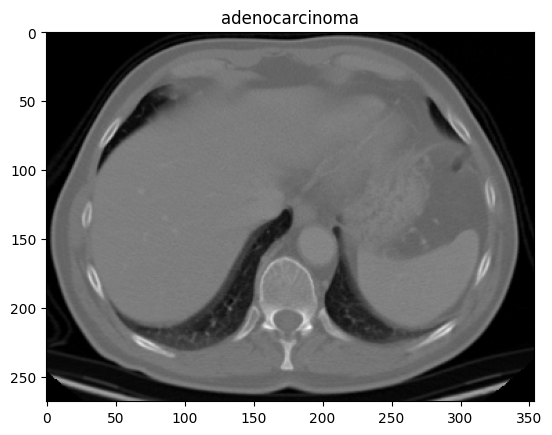

In [ ]:
r = see_random_image(train_dir, random.choice(class_names))

The above cell allows us to see random lung images (normal & abnoral), running it multiple times we can note several differences between the categories.

## Preprocessing the images

In [4]:
IMG_SIZE = (305, 430)

train_data_feature_extr = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode = "categorical",
                                                                              image_size = IMG_SIZE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                      label_mode = "categorical",
                                                                      image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 613 files belonging to 5 classes.
Found 72 files belonging to 5 classes.
Found 315 files belonging to 5 classes.


## Building a CNN model

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience = 10, verbose = 1)

In [ ]:
tf.random.set_seed(42)

model1 = tf.keras.models.Sequential([
    Conv2D(filters = 10,
           kernel_size = 2,
           padding = "same",
           activation = "relu",
           input_shape = (305, 430, 3)),
    Conv2D(10, 2, activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 2, activation = "relu"),
    Conv2D(10, 2, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation = "softmax")
])

model1.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

history1 = model1.fit(train_data_feature_extr,
                      epochs = 50,
                      steps_per_epoch = len(train_data_feature_extr),
                      validation_data = validation_data,
                      validation_steps = len(validation_data),
                      callbacks = [es])

Epoch 1/50
20/20 [==============================] - 10s 175ms/step - loss: 148.6800 - accuracy: 0.3752 - val_loss: 31.6739 - val_accuracy: 0.4583
Epoch 2/50
20/20 [==============================] - 5s 199ms/step - loss: 11.4000 - accuracy: 0.6085 - val_loss: 8.1769 - val_accuracy: 0.4861
Epoch 3/50
20/20 [==============================] - 5s 165ms/step - loss: 0.8372 - accuracy: 0.8630 - val_loss: 3.0730 - val_accuracy: 0.6250
Epoch 4/50
20/20 [==============================] - 4s 151ms/step - loss: 0.2641 - accuracy: 0.9233 - val_loss: 4.3137 - val_accuracy: 0.6528
Epoch 5/50
20/20 [==============================] - 6s 236ms/step - loss: 0.2108 - accuracy: 0.9429 - val_loss: 2.6913 - val_accuracy: 0.6389
Epoch 6/50
20/20 [==============================] - 4s 151ms/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 2.3564 - val_accuracy: 0.6667
Epoch 7/50
20/20 [==============================] - 4s 149ms/step - loss: 0.1020 - accuracy: 0.9935 - val_loss: 2.6779 - val_accuracy: 0.6389
E

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 305, 430, 10)      130       
                                                                 
 conv2d_21 (Conv2D)          (None, 304, 429, 10)      410       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 152, 214, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 151, 213, 10)      410       
                                                                 
 conv2d_23 (Conv2D)          (None, 150, 212, 10)      410       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 106, 10)      0         
 g2D)                                                 

In [ ]:
model1_res = model1.evaluate(test_data)

10/10 [==============================] - 2s 55ms/step - loss: 7.3495 - accuracy: 0.4095


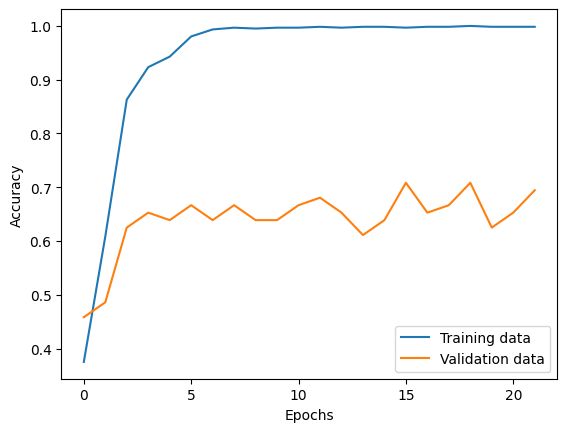

In [ ]:
plt.plot(history1.history['accuracy'], label = "Training data")
plt.plot(history1.history['val_accuracy'], label = "Validation data")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Transfer Learning: Feature extraction & Fine tuning

### Model 1: Feature extraction without data augmentation

In [ ]:
input_shape = (305, 430, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "inputs_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling")(x)
outputs = Dense(5, activation = "softmax", name = "output_layer")(x)

model_1_transfer = tf.keras.Model(inputs, outputs)
model_1_transfer.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1_transfer.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_layer (InputLayer)   [(None, 305, 430, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
checkpoint_path = "chest_checkpoint/feature_extraction"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True)

In [ ]:
initial_epochs = 70

history_transfer_model1 = model_1_transfer.fit(train_data_feature_extr,
                                               validation_data = validation_data,
                                               epochs = initial_epochs,
                                               steps_per_epoch = len(train_data_feature_extr),
                                               validation_steps = len(validation_data),
                                               callbacks = [checkpoint_callback, es])

In [ ]:
results_extraction_model1 = model_1_transfer.evaluate(test_data)

10/10 [==============================] - 3s 162ms/step - loss: 0.6077 - accuracy: 0.7810


In [ ]:
results_extr1_train = model_1_transfer.evaluate(train_data_feature_extr)

20/20 [==============================] - 11s 313ms/step - loss: 0.0924 - accuracy: 0.9967


In [ ]:
results_extraction_model1

[0.6076866984367371, 0.7809523940086365]

Our first feature extraction model does learn something, however, it performs much better on the training data than on the test data. Let's see if teh model performs better with fine tuning.

#### Model 1.2: fine tuning, adjusting the learning rate and training time

In [ ]:
for layer in model_1_transfer.layers:
  print(layer.name, layer.trainable)

inputs_layer True
efficientnetb0 False
pooling True
output_layer True


In [ ]:
for layer in base_model.layers:
  if "conv" in layer.name:
    layer.trainable = True

In [ ]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

Since we changed the convolutional layers from non-trainable to trainable, we need to recompile the model and fit it to the data again so that the trainable layers can learn the specificities of our data.

In [ ]:
model_1_transfer.compile(loss = "categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(0.01),
                         metrics = ["accuracy"])

In [ ]:
history_fine1 = model_1_transfer.fit(train_data_feature_extr,
                                    validation_data = validation_data,
                                    epochs = initial_epochs + 70,
                                    initial_epoch = history_transfer_model1.epoch[-1],
                                    callbacks = [es])

Epoch 34/140
20/20 [==============================] - 14s 289ms/step - loss: 0.1762 - accuracy: 0.9380 - val_loss: 0.5604 - val_accuracy: 0.7917
Epoch 35/140
20/20 [==============================] - 6s 258ms/step - loss: 0.1684 - accuracy: 0.9429 - val_loss: 0.7548 - val_accuracy: 0.7639
Epoch 36/140
20/20 [==============================] - 5s 202ms/step - loss: 0.0868 - accuracy: 0.9886 - val_loss: 0.5603 - val_accuracy: 0.7917
Epoch 37/140
20/20 [==============================] - 6s 235ms/step - loss: 0.0701 - accuracy: 0.9918 - val_loss: 0.5728 - val_accuracy: 0.8472
Epoch 38/140
20/20 [==============================] - 6s 194ms/step - loss: 0.0616 - accuracy: 0.9935 - val_loss: 0.6203 - val_accuracy: 0.7917
Epoch 39/140
20/20 [==============================] - 5s 207ms/step - loss: 0.0573 - accuracy: 0.9951 - val_loss: 0.5514 - val_accuracy: 0.8611
Epoch 40/140
20/20 [==============================] - 7s 258ms/step - loss: 0.0511 - accuracy: 0.9951 - val_loss: 0.5490 - val_accuracy

In [ ]:
results_fine_lr = model_1_transfer.evaluate(test_data)

10/10 [==============================] - 3s 154ms/step - loss: 0.6318 - accuracy: 0.8063


In [ ]:
results_fine_train = model_1_transfer.evaluate(train_data_feature_extr)

20/20 [==============================] - 8s 217ms/step - loss: 0.0267 - accuracy: 0.9984


Fine tuning and increased number of epochs helped increase the testing accuracy by around 9%, however, the accuracy gap between the training and testing performance remained. Looking at the model's training process, we can see that it stops improving, so let's implement EarlyStopping and DropOut to reduce overfitting.

### Model 2: Adding DropOut to reduce overfitting

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_layer")(x)
x = tf.keras.layers.Dropout(0.5, name = "Dropout_layer")(x)
x = tf.keras.layers.Flatten(name = "flattening")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.01),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 305, 430, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 flattening (Flatten)        (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                           

In [ ]:
e_s = tf.keras.callbacks.EarlyStopping(patience = 15, verbose=1)

In [ ]:
history_model2 = model_2.fit(train_data_feature_extr,
                             validation_data = validation_data,
                             epochs = initial_epochs,
                             steps_per_epoch = len(train_data_feature_extr),
                             validation_steps = len(validation_data),
                             callbacks = [e_s])

Epoch 1/70
20/20 [==============================] - 6s 200ms/step - loss: 0.3267 - accuracy: 0.8777 - val_loss: 0.6341 - val_accuracy: 0.7778
Epoch 2/70
20/20 [==============================] - 6s 238ms/step - loss: 0.2870 - accuracy: 0.8956 - val_loss: 0.5860 - val_accuracy: 0.7639
Epoch 3/70
20/20 [==============================] - 5s 197ms/step - loss: 0.2940 - accuracy: 0.8923 - val_loss: 0.6364 - val_accuracy: 0.7500
Epoch 4/70
20/20 [==============================] - 5s 209ms/step - loss: 0.2991 - accuracy: 0.8809 - val_loss: 0.5435 - val_accuracy: 0.8056
Epoch 5/70
20/20 [==============================] - 5s 208ms/step - loss: 0.2834 - accuracy: 0.8728 - val_loss: 0.7285 - val_accuracy: 0.7361
Epoch 6/70
20/20 [==============================] - 6s 225ms/step - loss: 0.2800 - accuracy: 0.8940 - val_loss: 0.5329 - val_accuracy: 0.8194
Epoch 7/70
20/20 [==============================] - 5s 205ms/step - loss: 0.3036 - accuracy: 0.8923 - val_loss: 0.6175 - val_accuracy: 0.7778
Epoch 

In [ ]:
results_model2 = model_2.evaluate(test_data)

10/10 [==============================] - 3s 159ms/step - loss: 0.6944 - accuracy: 0.7968


In [ ]:
results_model2_train = model_2.evaluate(train_data_feature_extr)

20/20 [==============================] - 5s 164ms/step - loss: 0.1303 - accuracy: 0.9494


The gap between the training and testing accuracy did not decrease and the tresting accuracy went down by 3% (as compared to model 1). Let's try to fine tune the model.

#### Model 2.1: Fine tuning

In [ ]:
for layer in base_model.layers:
  if "conv" in layer.name:
    layer.trainable = True

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.01),
                metrics = ['accuracy'])

In [ ]:
history_model2_fine = model_2.fit(train_data_feature_extr,
                                  validation_data = validation_data,
                                  epochs = initial_epochs + 60,
                                  steps_per_epoch = len(train_data_feature_extr),
                                  validation_steps = len(validation_data),
                                  initial_epoch = history_model2.epoch[-1],
                                  callbacks = [e_s])

Epoch 23/130
20/20 [==============================] - 18s 323ms/step - loss: 0.3232 - accuracy: 0.8809 - val_loss: 0.7251 - val_accuracy: 0.8333
Epoch 24/130
20/20 [==============================] - 5s 199ms/step - loss: 0.3201 - accuracy: 0.8662 - val_loss: 0.6720 - val_accuracy: 0.7917
Epoch 25/130
20/20 [==============================] - 6s 263ms/step - loss: 0.2149 - accuracy: 0.9119 - val_loss: 0.5668 - val_accuracy: 0.8194
Epoch 26/130
20/20 [==============================] - 5s 207ms/step - loss: 0.2230 - accuracy: 0.9135 - val_loss: 0.6139 - val_accuracy: 0.8194
Epoch 27/130
20/20 [==============================] - 6s 237ms/step - loss: 0.2447 - accuracy: 0.9086 - val_loss: 0.7680 - val_accuracy: 0.7917
Epoch 28/130
20/20 [==============================] - 6s 190ms/step - loss: 0.2365 - accuracy: 0.9119 - val_loss: 0.5613 - val_accuracy: 0.8194
Epoch 29/130
20/20 [==============================] - 5s 210ms/step - loss: 0.2679 - accuracy: 0.8793 - val_loss: 0.6807 - val_accuracy

In [ ]:
results_model2_fine = model_2.evaluate(test_data)

10/10 [==============================] - 3s 154ms/step - loss: 0.9578 - accuracy: 0.7397


In [ ]:
results_model2_fine_train = model_2.evaluate(train_data_feature_extr)

20/20 [==============================] - 5s 166ms/step - loss: 0.0353 - accuracy: 0.9951


We can see that despite adding a Dropout layer, the model still overfits. Moreover, the model also performed worse on the testing data than model 1.2, by about 2%.

### Model 3: Feature extraction with data augmentation

In [ ]:
input_shape = (305, 430, 3)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.1),
    tf.keras.layers.RandomWidth(0.1)
], name = "data_augmentation")

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "inputs")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling")(x)
x = tf.keras.layers.Dropout(0.4, name = "dropout_layer")(x)
x = tf.keras.layers.Flatten(name = "flattening")(x)
x = tf.keras.layers.BatchNormalization(name = "normalizing")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax", name = "outputs")(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss = "categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(0.01),
                         metrics = ["accuracy"])

In [ ]:
model_3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 305, 430, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 flattening (Flatten)        (None, 1280)              0   

In [ ]:
checkpoint_path2 = "chest_checkpoint/chest_feature_ext_data_aug"

checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path2,
                                                         save_best_only = True,
                                                         save_weights_only = True)

In [ ]:
history_model3 = model_3.fit(train_data_feature_extr,
                             validation_data = validation_data,
                             epochs = 50,
                             steps_per_epoch = len(train_data_feature_extr),
                             validation_steps = len(validation_data),
                             callbacks = [e_s, checkpoint_callback2])

Epoch 1/50
20/20 [==============================] - 14s 609ms/step - loss: 0.9086 - accuracy: 0.7651 - val_loss: 1.7956 - val_accuracy: 0.6528
Epoch 2/50
20/20 [==============================] - 20s 804ms/step - loss: 0.8401 - accuracy: 0.7667 - val_loss: 1.5774 - val_accuracy: 0.6806
Epoch 3/50
20/20 [==============================] - 15s 473ms/step - loss: 0.9358 - accuracy: 0.7292 - val_loss: 1.9893 - val_accuracy: 0.6111
Epoch 4/50
20/20 [==============================] - 9s 366ms/step - loss: 0.7907 - accuracy: 0.7618 - val_loss: 1.7841 - val_accuracy: 0.7083
Epoch 5/50
20/20 [==============================] - 10s 421ms/step - loss: 0.9366 - accuracy: 0.7341 - val_loss: 1.8961 - val_accuracy: 0.5833
Epoch 6/50
20/20 [==============================] - 9s 406ms/step - loss: 0.8909 - accuracy: 0.7520 - val_loss: 1.4160 - val_accuracy: 0.6528
Epoch 7/50
20/20 [==============================] - 8s 330ms/step - loss: 0.8029 - accuracy: 0.7635 - val_loss: 1.4670 - val_accuracy: 0.7222
Ep

In [ ]:
results_3 = model_3.evaluate(test_data)

10/10 [==============================] - 3s 153ms/step - loss: 1.5812 - accuracy: 0.5937


#### Model 3.2: Fine-tuning

In [ ]:
for layer in base_model.layers:
  if "conv" in layer.name:
    layer.trainable = True

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.01),
                metrics = ["accuracy"])

In [ ]:
history_3_fine = model_3.fit(train_data_feature_extr,
                             validation_data = validation_data,
                             epochs = 70,
                             initial_epoch = history_model3.epoch[-1],
                             callbacks = [e_s])

Epoch 21/70
20/20 [==============================] - 25s 464ms/step - loss: 0.9144 - accuracy: 0.7276 - val_loss: 1.6709 - val_accuracy: 0.6528
Epoch 22/70
20/20 [==============================] - 8s 355ms/step - loss: 0.7667 - accuracy: 0.7700 - val_loss: 1.4333 - val_accuracy: 0.6667
Epoch 23/70
20/20 [==============================] - 9s 330ms/step - loss: 0.9597 - accuracy: 0.7569 - val_loss: 1.9241 - val_accuracy: 0.6389
Epoch 24/70
20/20 [==============================] - 8s 346ms/step - loss: 0.8487 - accuracy: 0.7520 - val_loss: 1.8838 - val_accuracy: 0.6111
Epoch 25/70
20/20 [==============================] - 8s 357ms/step - loss: 0.8219 - accuracy: 0.7700 - val_loss: 1.5274 - val_accuracy: 0.6806
Epoch 26/70
20/20 [==============================] - 8s 296ms/step - loss: 0.7348 - accuracy: 0.7504 - val_loss: 1.5954 - val_accuracy: 0.6389
Epoch 27/70
20/20 [==============================] - 9s 322ms/step - loss: 0.8277 - accuracy: 0.7602 - val_loss: 1.8100 - val_accuracy: 0.652

In [ ]:
res_model3 = model_3.evaluate(test_data)

10/10 [==============================] - 7s 167ms/step - loss: 1.3191 - accuracy: 0.5714


### Results: EfficientNet

We have created a lot of models! Let's create a simple visualisation to compare their performance and choose the best one!

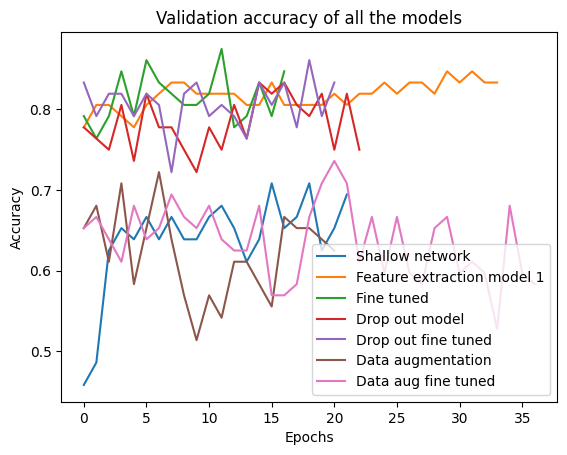

In [ ]:
plt.plot(history1.history['val_accuracy'], label = "Shallow network")
plt.plot(history_transfer_model1.history['val_accuracy'], label = "Feature extraction model 1")
plt.plot(history_fine1.history['val_accuracy'], label = "Fine tuned")
plt.plot(history_model2.history['val_accuracy'], label = "Drop out model")
plt.plot(history_model2_fine.history['val_accuracy'], label = "Drop out fine tuned")
plt.plot(history_model3.history['val_accuracy'], label = "Data augmentation")
plt.plot(history_3_fine.history['val_accuracy'], label = "Data aug fine tuned")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation accuracy of all the models")
plt.show()

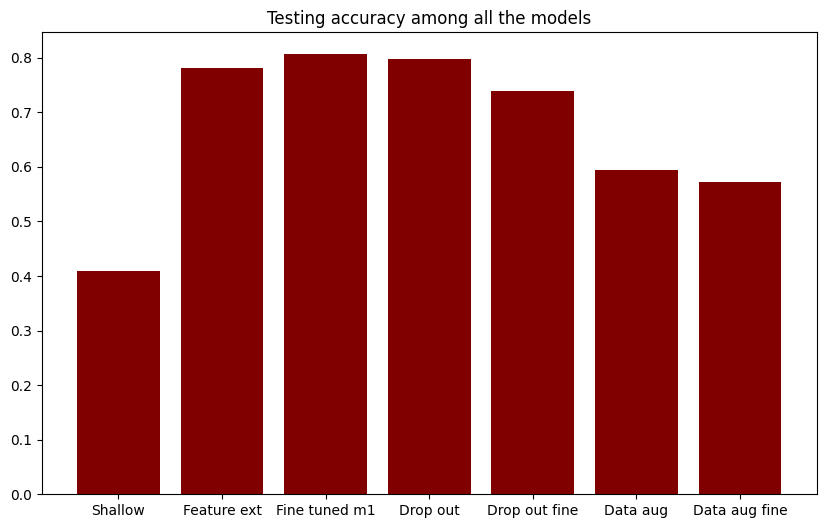

In [ ]:
labels = ["Shallow","Feature ext", "Fine tuned m1", "Drop out",
          "Drop out fine",
          "Data aug", "Data aug fine"]
vals = [model1_res[1], results_extraction_model1[1], results_fine_lr[1],
        results_model2[1], results_model2_fine[1], results_3[1], res_model3[1]]
plt.figure(figsize = (10, 6))
plt.bar(labels, vals, color = 'maroon')
plt.title("Testing accuracy among all the models")
plt.show()

Fine tuned model 1 (without fine tuning or drop out layer) performs the best on unseen data as we can see from teh chart above. Let's try and improve it further.

### Model 1: Improvements

In [9]:
input_shape = (305, 430, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "inputs_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling")(x)
x = tf.keras.layers.Flatten(name = "flattening_layer")(x)
x = tf.keras.layers.BatchNormalization(name = "Normalization_layer")(x)
outputs = Dense(5, activation = "softmax", name = "output_layer")(x)

model_1_improved = tf.keras.Model(inputs, outputs)
model_1_improved.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [10]:
model_1_improved.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_layer (InputLayer)   [(None, 305, 430, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 flattening_layer (Flatten)  (None, 1280)              0         
                                                                 
 Normalization_layer (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 output_layer (Dense)        (None, 5)                 6405

Before fine tuning, we need to train the model on our data for a little bit first.

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 20)

improved_model1_history = model_1_improved.fit(train_data_feature_extr,
                                               validation_data = validation_data,
                                               epochs = 80,
                                               callbacks = [early_stopping])

Epoch 1/80
20/20 [==============================] - 169s 4s/step - loss: 1.2204 - accuracy: 0.5041 - val_loss: 1.1588 - val_accuracy: 0.4583
Epoch 2/80
20/20 [==============================] - 6s 260ms/step - loss: 0.6646 - accuracy: 0.7471 - val_loss: 1.0863 - val_accuracy: 0.4722
Epoch 3/80
20/20 [==============================] - 5s 202ms/step - loss: 0.4677 - accuracy: 0.8369 - val_loss: 1.0630 - val_accuracy: 0.5278
Epoch 4/80
20/20 [==============================] - 6s 224ms/step - loss: 0.3637 - accuracy: 0.8923 - val_loss: 0.9642 - val_accuracy: 0.5417
Epoch 5/80
20/20 [==============================] - 6s 207ms/step - loss: 0.2787 - accuracy: 0.9315 - val_loss: 0.9423 - val_accuracy: 0.5278
Epoch 6/80
20/20 [==============================] - 5s 204ms/step - loss: 0.2474 - accuracy: 0.9315 - val_loss: 0.8973 - val_accuracy: 0.5972
Epoch 7/80
20/20 [==============================] - 7s 252ms/step - loss: 0.1930 - accuracy: 0.9576 - val_loss: 0.8409 - val_accuracy: 0.6389
Epoch 8

In [12]:
results_model1_improved = model_1_improved.evaluate(test_data)

10/10 [==============================] - 75s 905ms/step - loss: 0.6507 - accuracy: 0.8127


Now it's time for fine-tuning!

In [13]:
for layer in base_model.layers:
  if "conv5" in layer.name:
    layer.trainable = True

In [33]:
model_1_improved.compile(loss = "categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(0.001),
                         metrics = ["accuracy"])

model1_impr_fine_hist = model_1_improved.fit(train_data_feature_extr,
                                             validation_data = validation_data,
                                             epochs = 100,
                                             initial_epoch = improved_model1_history.epoch[-1],
                                             callbacks = [early_stopping])

Epoch 38/100
20/20 [==============================] - 16s 341ms/step - loss: 0.0259 - accuracy: 0.9967 - val_loss: 2.7911 - val_accuracy: 0.7917
Epoch 39/100
20/20 [==============================] - 5s 204ms/step - loss: 0.0080 - accuracy: 0.9984 - val_loss: 2.7152 - val_accuracy: 0.7917
Epoch 40/100
20/20 [==============================] - 5s 206ms/step - loss: 0.0105 - accuracy: 0.9935 - val_loss: 2.6733 - val_accuracy: 0.8333
Epoch 41/100
20/20 [==============================] - 6s 243ms/step - loss: 0.0207 - accuracy: 0.9967 - val_loss: 2.7158 - val_accuracy: 0.8056
Epoch 42/100
20/20 [==============================] - 6s 206ms/step - loss: 0.0130 - accuracy: 0.9984 - val_loss: 2.8825 - val_accuracy: 0.8056
Epoch 43/100
20/20 [==============================] - 7s 248ms/step - loss: 0.0263 - accuracy: 0.9984 - val_loss: 2.8923 - val_accuracy: 0.8056
Epoch 44/100
20/20 [==============================] - 5s 198ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 2.9096 - val_accuracy

In [34]:
model_1_improved.evaluate(test_data)

10/10 [==============================] - 3s 156ms/step - loss: 2.3638 - accuracy: 0.8222


[2.363811492919922, 0.8222222328186035]

The accuracy imrpoved by only 1%, however, I did not implement any major changes except for BatchNormalization. This is because I implemented other ways to reduce overfitting (DropOut, Data Augmentation, Early stopping, etc) earlier. Since they did not lead to any improvement in the model performance, I decided to use the better-performing model as a base and try something that I have not tried yet. While 82% is not the best accuracy, this is the best performance out of all the models I have created in this notebook. So, fine tuned efficient net b0 model (+batch normalization and early stopping) is the best performing model on the test data set in this notebook.